In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

folder_path = "20230530_segm_black_mouse_mnSLA_red_and_black_back"

seed_value = 52
torch.manual_seed(seed_value)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [133]:
def augmentation():
    count_image = 800
    path_images = "20230530_segm_black_mouse_mnSLA_red_and_black_back/images"
    path_masks = "20230530_segm_black_mouse_mnSLA_red_and_black_back/masks"

    image_files = os.listdir(path_images)
    selected_files_for_vertical = random.sample(image_files, count_image)

    for filename in selected_files_for_vertical:
        image_path = os.path.join(path_images, filename)
        image = Image.open(image_path)
        rotated_image = image.transpose(Image.FLIP_LEFT_RIGHT)
        output_path = os.path.join(path_images, f'revert_vertical_{filename}')
        rotated_image.save(output_path)
        image.close()

        mask_path = os.path.join(path_masks, filename)
        mask = Image.open(mask_path)
        rotated_mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        output_path = os.path.join(path_masks, f'revert_vertical_{filename}')
        rotated_mask.save(output_path)
        mask.close()

    # selected_files_for_horizontal = []
    count_image = 800
    selected_files_for_horizontal = random.sample(image_files, count_image)

    for filename in selected_files_for_horizontal:
        image_path = os.path.join(path_images, filename)
        image = Image.open(image_path)
        rotated_image = image.transpose(Image.FLIP_TOP_BOTTOM)
        output_path = os.path.join(path_images, f'revert_horizontal_{filename}')
        rotated_image.save(output_path)
        image.close()

        mask_path = os.path.join(path_masks, filename)
        mask = Image.open(mask_path)
        rotated_mask = mask.transpose(Image.FLIP_TOP_BOTTOM)
        output_path = os.path.join(path_masks, f'revert_horizontal_{filename}')
        rotated_mask.save(output_path)
        mask.close()

    return selected_files_for_vertical, selected_files_for_horizontal


def delete_generated_images(data_vert, data_hor):
    path_images = "20230530_segm_black_mouse_mnSLA_red_and_black_back/images"
    path_masks = "20230530_segm_black_mouse_mnSLA_red_and_black_back/masks"

    for filename in data_vert:
        output_image_path = os.path.join(path_images, f'revert_vertical_{filename}')
        os.remove(output_image_path)

        output_mask_path = os.path.join(path_masks, f'revert_vertical_{filename}')
        os.remove(output_mask_path)

    for filename in data_hor:
        output_image_path = os.path.join(path_images, f'revert_horizontal_{filename}')
        os.remove(output_image_path)

        output_mask_path = os.path.join(path_masks, f'revert_horizontal_{filename}')
        os.remove(output_mask_path)

In [134]:
def make_csv_files(folder_path, folder):
    images_folder = folder_path + "/" + folder + "images"
    masks_folder = folder_path + "/" + folder + "masks"

    images_files = os.listdir(images_folder)
    masks_files = os.listdir(masks_folder)

    image_paths = [os.path.join(folder + "images", file) for file in images_files]
    mask_paths = [os.path.join(folder + "masks", file) for file in masks_files]

    data = {'orig_image': image_paths, 'mask_image': mask_paths}
    df = pd.DataFrame(data)

    csv_file_path = "train_data.csv" if folder == "" else "test_data.csv"

    df.to_csv(csv_file_path, index=False)

In [136]:
data_vertical, data_horizontal = augmentation()
make_csv_files(folder_path, "")
make_csv_files(folder_path, "test_")

In [137]:
train_df = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

In [138]:
def draw(orig_image, orig_masks, mask_image, intersec_mask):
    fig, axes = plt.subplots(1, 4)

    orig_image = orig_image.transpose(1, 2, 0)
    orig_image = (np.array(orig_image) - np.min(orig_image)) / (np.max(orig_image) - np.min(orig_image))
    axes[0].imshow(orig_image)
    axes[0].set_title('Original Image')

    axes[1].imshow(orig_masks)
    axes[1].set_title('Original Mask')
    
    axes[2].imshow(mask_image)
    axes[2].set_title('Predicted Mask')

    axes[3].imshow(intersec_mask)
    axes[3].set_title('Difference Mask')

    plt.tight_layout()
    plt.show()

In [139]:
def calculate_iou(predictions, targets):
    total_sum = 0.0
    for prediction, target in zip(predictions, targets):
        intersection = np.logical_and(prediction, target).sum().item()
        union = np.logical_or(prediction, target).sum().item()
        
        total_sum += intersection / union if union > 0 else 0.0

    return total_sum / len(predictions)

In [140]:
def compute_ap(predictions, targets):
    total_sum = 0.0
    thresholds = np.linspace(0, 1, 100)
    precisions = []
    recalls = []
    eps = 1e-7
    for prediction, target in zip(predictions, targets):
        for threshold in thresholds:
            output_thresh = (prediction>= threshold).astype(float)
            tp = np.sum(output_thresh * target)
            fp = np.sum(output_thresh * (1 - target))
            fn = np.sum((1 - output_thresh) * target)
            precisions.append((tp + eps) / (tp + fp + eps))
            recalls.append((tp + eps) / (tp + fn + eps))

        total_sum += np.trapz(precisions, recalls)
    return total_sum / len(predictions)

### Preprocessing (подготовка данных)

In [141]:
class ImagesDataset(Dataset):
    def __init__(self, folder, data, transform_image, transform_mask):
      self.folder = folder
      self.data = data.copy()
      self.orig_image_paths = [os.path.join(folder, filename) for filename in data['orig_image'].copy()]
      self.mask_image_paths = [os.path.join(folder, filename) for filename in data['mask_image'].copy()]
      self.transform_image = transform_image
      self.transform_mask = transform_mask

    def __len__(self):
        return len(self.orig_image_paths)

    def __getitem__(self, idx):
        orig_image_path = self.orig_image_paths[idx]
        mask_image_path = self.mask_image_paths[idx]
        orig_image = Image.open(orig_image_path).convert('RGB')
        mask_image = Image.open(mask_image_path).convert('L')

        orig_image = self.transform_image(orig_image)
        orig_image = orig_image.to(orig_image)
        
        mask_image = self.transform_mask(mask_image)
        mask_image = mask_image.to(mask_image)

        return orig_image.float(), mask_image.float()

In [142]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df, test_size=0.1 , random_state=42)

size = (320, 320)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
batch_size = 16

transform_image = transforms.Compose([transforms.Resize(size), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

transform_mask = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])

train_dataset = ImagesDataset(folder_path, train, transform_image, transform_mask)
val_dataset = ImagesDataset(folder_path, val, transform_image, transform_mask)
test_dataset = ImagesDataset(folder_path, test, transform_image, transform_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training/evaluation loop

In [143]:
def learning(num_epochs, train_load, val_load, model, optimizer, criterion):
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in tqdm(train_load):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_load))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_load):
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)
          outputs = model(x_batch)
          loss = criterion(outputs, y_batch)
          val_loss += (loss.item())
    val_losses.append(val_loss/len(val_load))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
  return model, train_losses, val_losses

### Prediction function

In [144]:
def prediction(model, loader):
    model.eval()
    predictions = []
    orig_images = []
    orig_masks = []
    intersection_masks = []
    with torch.no_grad():
        for x_batch, y_batch in tqdm(loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            outputs[outputs < 0] = 0
            outputs[outputs > 0] = 1
            predictions.append(outputs.cpu().numpy())
            orig_images.append(x_batch.cpu().numpy())
            orig_masks.append(y_batch.cpu().numpy())
            intersection = np.abs(outputs.cpu().numpy() - y_batch.cpu().numpy())
            intersection_masks.append(intersection)
    predictions = np.concatenate(predictions, axis=0).squeeze()
    orig_images = np.concatenate(orig_images, axis=0).squeeze()
    orig_masks = np.concatenate(orig_masks, axis=0).squeeze()
    intersection_masks = np.concatenate(intersection_masks, axis=0).squeeze()
    return predictions, orig_images, orig_masks, intersection_masks

In [145]:
def validation(model, loader, images_to_draw):
    predictions, orig_images, orig_masks, intersection_masks = prediction(model, loader)

    iou = calculate_iou(predictions, orig_masks)
    ap = compute_ap(predictions, orig_masks)

    print(f"IOU: {iou}")
    print(f"AP: {ap}")

    for i in range(images_to_draw):
        draw(orig_images[i], orig_masks[i], predictions[i], intersection_masks[i])


### Experiments

In [146]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv
    
def padder(left_tensor, right_tensor): 
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(device)
    
    return right_tensor.to(device)

In [147]:
class UNET(nn.Module):
    def __init__(self,in_chnls, n_classes):
        super(UNET,self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        
        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)
        
        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.n_classes,kernel_size=1,stride=1)
        
    def forward(self,x):
        x1 = self.down_conv_1(x)
        p1 = self.max_pool(x1)
        x2 = self.down_conv_2(p1)
        p2 = self.max_pool(x2)
        x3 = self.down_conv_3(p2)
        p3 = self.max_pool(x3)
        x4 = self.down_conv_4(p3)
        p4 = self.max_pool(x4)
        x5 = self.down_conv_5(p4)
        
        d1 = self.up_conv_trans_1(x5)
        pad1 = padder(x4,d1)
        cat1 = torch.cat([x4,pad1],dim=1)
        uc1 = self.up_conv_1(cat1)
        
        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2)
        cat2 = torch.cat([x3,pad2],dim=1)
        uc2 = self.up_conv_2(cat2)
        
        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1

In [148]:
model = UNET(in_chnls = 3, n_classes = 1).to(device)

In [149]:
import segmentation_models_pytorch as smp
model = smp.Unet('resnet152', classes=1)
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [150]:
learning_rate = 0.001
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

In [151]:
num_epochs = 60
model, train_losses, val_losses = learning(num_epochs, train_loader, val_loader, model, optimizer, criterion)

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Losses', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(val_losses, label='Validation Losses', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()
plt.tight_layout()
plt.show()

100%|██████████| 41/41 [00:09<00:00,  4.21it/s]


Epoch [1/60], Train loss: 20.3599, Val loss: 0.6119


100%|██████████| 41/41 [00:07<00:00,  5.46it/s]


Epoch [2/60], Train loss: 4.1012, Val loss: 0.3717


100%|██████████| 41/41 [00:07<00:00,  5.57it/s]


Epoch [3/60], Train loss: 2.8581, Val loss: 0.2894


100%|██████████| 41/41 [00:07<00:00,  5.47it/s]


Epoch [4/60], Train loss: 2.3373, Val loss: 0.2551


100%|██████████| 41/41 [00:09<00:00,  4.22it/s]


Epoch [5/60], Train loss: 2.0505, Val loss: 0.2436


100%|██████████| 41/41 [00:07<00:00,  5.26it/s]


Epoch [6/60], Train loss: 1.8725, Val loss: 0.2285


100%|██████████| 41/41 [00:07<00:00,  5.56it/s]


Epoch [7/60], Train loss: 1.7427, Val loss: 0.2145


100%|██████████| 41/41 [00:07<00:00,  5.47it/s]


Epoch [8/60], Train loss: 1.6316, Val loss: 0.2007


100%|██████████| 41/41 [00:07<00:00,  5.49it/s]


Epoch [9/60], Train loss: 1.5640, Val loss: 0.1946


100%|██████████| 41/41 [00:07<00:00,  5.51it/s]


Epoch [10/60], Train loss: 1.4551, Val loss: 0.1893


100%|██████████| 41/41 [00:07<00:00,  5.51it/s]


Epoch [11/60], Train loss: 1.3339, Val loss: 0.1847


100%|██████████| 41/41 [00:07<00:00,  5.48it/s]


Epoch [12/60], Train loss: 1.3217, Val loss: 0.1840


100%|██████████| 41/41 [00:07<00:00,  5.49it/s]


Epoch [13/60], Train loss: 1.3288, Val loss: 0.1893


100%|██████████| 41/41 [00:07<00:00,  5.50it/s]


Epoch [14/60], Train loss: 1.3151, Val loss: 0.1897


100%|██████████| 41/41 [00:10<00:00,  4.09it/s]


Epoch [15/60], Train loss: 1.2948, Val loss: 0.1849


100%|██████████| 41/41 [00:10<00:00,  4.08it/s]


Epoch [16/60], Train loss: 1.2287, Val loss: 0.1781


100%|██████████| 41/41 [00:09<00:00,  4.10it/s]


Epoch [17/60], Train loss: 1.1602, Val loss: 0.1739


100%|██████████| 41/41 [00:10<00:00,  4.06it/s]


Epoch [18/60], Train loss: 1.1356, Val loss: 0.1777


100%|██████████| 41/41 [00:10<00:00,  4.07it/s]


Epoch [19/60], Train loss: 1.1519, Val loss: 0.1767


100%|██████████| 41/41 [00:09<00:00,  4.14it/s]


Epoch [20/60], Train loss: 1.1523, Val loss: 0.1808


100%|██████████| 41/41 [00:09<00:00,  4.14it/s]


Epoch [21/60], Train loss: 1.1677, Val loss: 0.1761


100%|██████████| 41/41 [00:07<00:00,  5.47it/s]


Epoch [22/60], Train loss: 1.1801, Val loss: 0.1735


100%|██████████| 41/41 [00:07<00:00,  5.47it/s]


Epoch [23/60], Train loss: 1.0708, Val loss: 0.1703


100%|██████████| 41/41 [00:07<00:00,  5.51it/s]


Epoch [24/60], Train loss: 1.0275, Val loss: 0.1715


100%|██████████| 41/41 [00:07<00:00,  5.49it/s]


Epoch [25/60], Train loss: 1.0216, Val loss: 0.1736


100%|██████████| 41/41 [00:07<00:00,  5.55it/s]


Epoch [26/60], Train loss: 1.0375, Val loss: 0.1741


100%|██████████| 41/41 [00:07<00:00,  5.49it/s]


Epoch [27/60], Train loss: 1.0650, Val loss: 0.1778


100%|██████████| 41/41 [00:08<00:00,  4.61it/s]


Epoch [28/60], Train loss: 1.0838, Val loss: 0.1767


100%|██████████| 41/41 [00:07<00:00,  5.49it/s]


Epoch [29/60], Train loss: 1.0681, Val loss: 0.1727


100%|██████████| 41/41 [00:07<00:00,  5.46it/s]


Epoch [30/60], Train loss: 1.0786, Val loss: 0.1782


100%|██████████| 41/41 [00:07<00:00,  5.51it/s]


Epoch [31/60], Train loss: 1.0702, Val loss: 0.1726


100%|██████████| 41/41 [00:07<00:00,  5.50it/s]


Epoch [32/60], Train loss: 1.0269, Val loss: 0.1748


100%|██████████| 41/41 [00:10<00:00,  4.02it/s]


Epoch [33/60], Train loss: 1.0310, Val loss: 0.1750


 20%|██        | 73/364 [00:29<01:57,  2.49it/s]


KeyboardInterrupt: 

### Evaluation (оценка качества модели)

In [152]:
validation(model, train_loader, 1)

 10%|▉         | 35/364 [00:07<01:09,  4.74it/s]


KeyboardInterrupt: 

100%|██████████| 41/41 [00:08<00:00,  4.97it/s]


IOU: 0.8546731514476206
AP: -0.01819477625194263


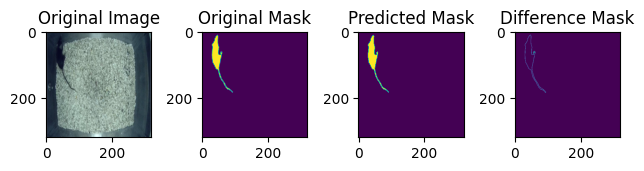

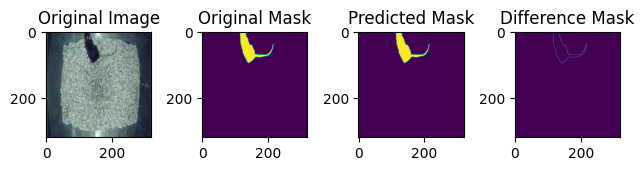

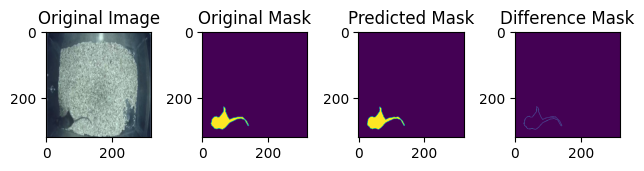

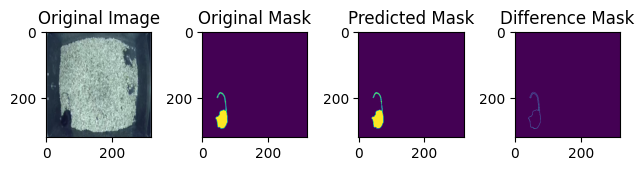

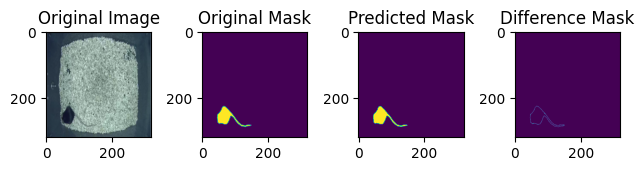

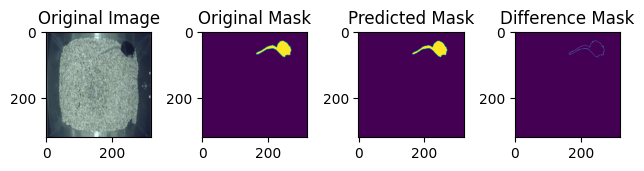

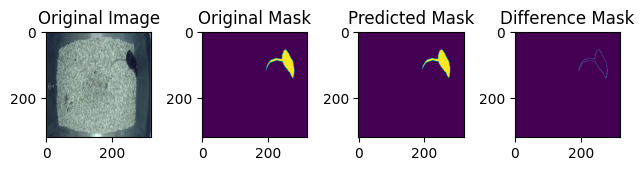

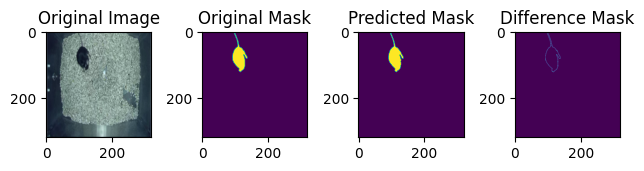

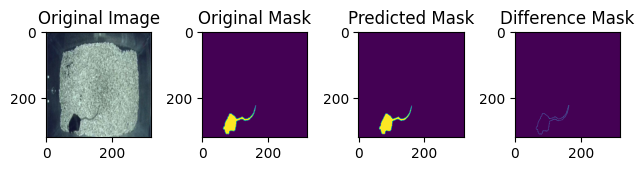

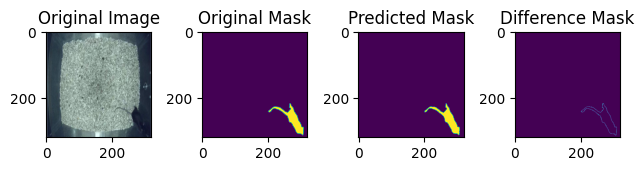

In [153]:
validation(model, val_loader, 10)

100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


IOU: 0.8275216676006505
AP: -0.03854246913926069


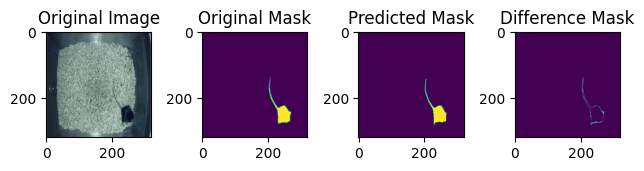

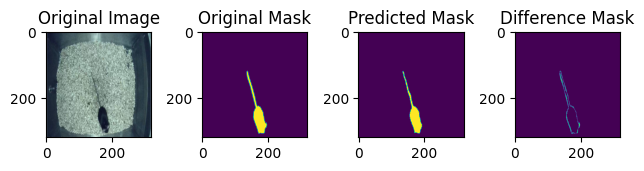

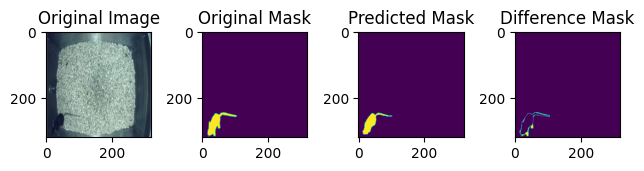

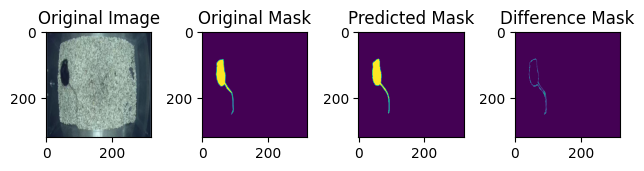

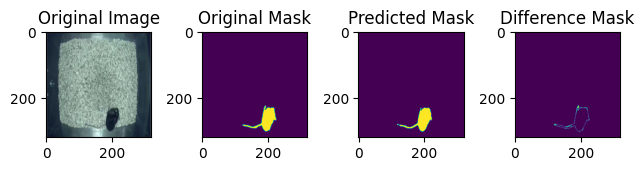

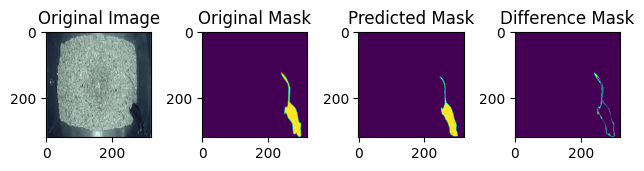

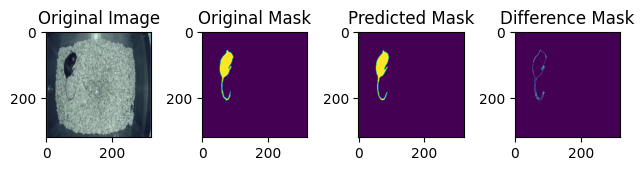

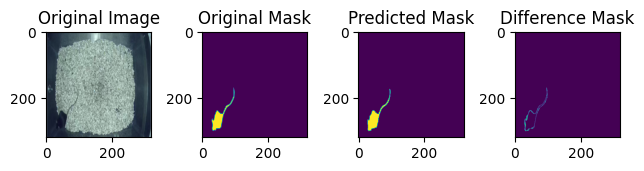

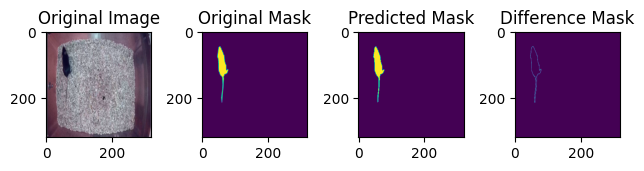

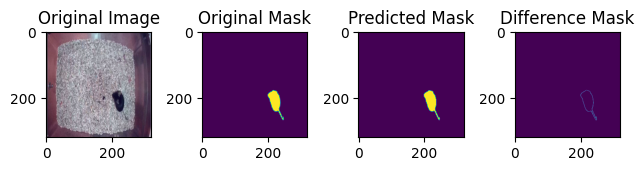

In [155]:
validation(model, test_loader, 10)

In [158]:
delete_generated_images(data_vertical, data_horizontal)

FileNotFoundError: [WinError 2] Не удается найти указанный файл: '20230530_segm_black_mouse_mnSLA_red_and_black_back/images\\revert_vertical_ch12_20230523180211_20230523190211@000648.bmp'